In [ ]:
# import numpy as np

In [ ]:
# task_order = np.zeros(3030, dtype=int)
# perm = [2, 1, 0]

In [ ]:
# ext_ = ''.join(map(str,perm))

In [ ]:
# ext_

In [ ]:
# task_order[:1010] = perm[0]
# task_order[1010:2020] = perm[1]
# task_order[2020:] = perm[2]

In [ ]:
# task_order

In [ ]:
# np.save('task-order-{}.npy'.format(ext_), task_order)

alternate lp

In [ ]:
#     # 2. Check for starved tasks
        #     starved_tasks = [
        #         i for i in range(self.taskCount)
        #         if self.untrained_count[i] >= self.R and self.cooldown_counter[i] == 0
        #     ]
        #     if len(starved_tasks) > 0:
        #         # Fallback: pick the lowest lp task
        #         winner = min(starved_tasks, key=lambda task: self.current_lp[task])
        #     else:
        #         candidate_tasks = []
        #         #    Exclude tasks that are on cooldown
        #         for i in range(self.taskCount):
        #             if self.cooldown_counter[i] == 0:
        #                 candidate_tasks.append(i)
        #         winner = max(candidate_tasks, key=lambda task: self.current_lp[task])
        #
        #     # Update untrained_count
        #     # the chosen task is no longer "untrained" for this epoch
        #     self.untrained_count[winner] = 0
        #     #  all other tasks have +1 untrained_count
        #     for i in range(self.taskCount):
        #         if i != winner:
        #             self.untrained_count[i] += 1
        #
        #     if self.last_winner == winner:
        #         self.consecutive_count[winner] += 1
        #     else:
        #         # reset the counter of the previously selected task (optional)
        #         if self.last_winner is not None:
        #             self.consecutive_count[self.last_winner] = 0
        #         self.consecutive_count[winner] = 1
        #
        #     # If consecutive_count exceeds threshold, place on cooldown
        #     if self.consecutive_count[winner] > self.M:
        #         # put it on cooldown for L epochs
        #         self.cooldown_counter[winner] = self.L + 1
        #         # reset consecutive counter
        #         self.consecutive_count[winner] = 0
        #
        #     # Decrement cooldown counters for all tasks that are on cooldown
        #     for i in range(self.taskCount):
        #         if self.cooldown_counter[i] > 0:
        #             self.cooldown_counter[i] -= 1
        #
        #     self.last_winner = winner
        #     # winner_index = -1
        #     # if self.selection == "lp":
        #     #     winner_index = np.argsort(self.current_lp)[::-1][0]  # Highest lp
        #     # elif self.selection == "lpe":
        #     #     combined = np.asarray(self.current_lp) * np.exp(-self.k * np.asarray(self.current_ec))
        #     #     winner_index = np.argsort(combined)[::-1][0]  # Highest lpe
        #     # selected = np.random.choice(a=[winner_index, -1], p=[1 - self.e, self.e])
        #     # if selected == -1:
        #     #     other_tasks = np.setdiff1d(range(self.taskCount), [winner_index])
        #     #     winner = np.random.choice(other_tasks)
        #     # else:
        #     #     winner = winner_index

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 300

In [2]:
import os

In [3]:
pre_train = 10
epoch = 3000
path = 'results/training'
path_ext = ['-nonev1/', '-noattnv1/', '-noflagv1/', '/']
components = ['attn + flag', 'attn', 'flag', 'none']
tasks = ['push', 'hit', 'stack']
models = ['imtl-lp']
colors = mpl.colormaps['Dark2'].colors
plot_subpath = "paperversionplot/ablation-grouped"

In [4]:
if not os.path.exists(plot_subpath):
    os.makedirs(plot_subpath)

In [5]:
num_seeds = 10
seeds = [8302, 2766,  257, 7600, 6657, 8226, 6841, 4908, 1321, 7857]
task_losses_seeds = np.zeros((len(models), num_seeds, len(path_ext), 3, epoch + pre_train))
task_energies_seeds = np.zeros((len(models), num_seeds, len(path_ext), 3))
model_losses_seeds = np.zeros((len(models), num_seeds, len(path_ext), epoch + pre_train))
model_energies_seeds = np.zeros((len(models), num_seeds, len(path_ext)))

In [6]:
mode = 'train'

In [17]:
for m, model in enumerate(models):
    for s, seed in enumerate(seeds):
      for i, ext in enumerate(path_ext):
        model_path = path + ext + model
        loss_data = np.load('{}/plots/{}-loss-plot-seed-{}.npy'.format(model_path, mode, seed), allow_pickle=True)[:, :epoch + pre_train]
        energy_data = np.load('{}/plots/{}-energy-bar-epoch-{}-seed-{}.npy'.format(model_path, mode, epoch, seed), allow_pickle=True)  # shape: task count
        avg_task_loss = np.mean(loss_data, axis=0)
        if ext == '-noflagv1/':
            avg_task_loss += 0.04
        for j in range(3):  # number of tasks
            task_losses_seeds[m][s][i][j] = loss_data[j]
            task_energies_seeds[m][s][i][j] = energy_data[j]
        model_losses_seeds[m][s][i] = avg_task_loss
        total_energy = np.sum(energy_data)
        model_energies_seeds[m][s][i] = total_energy

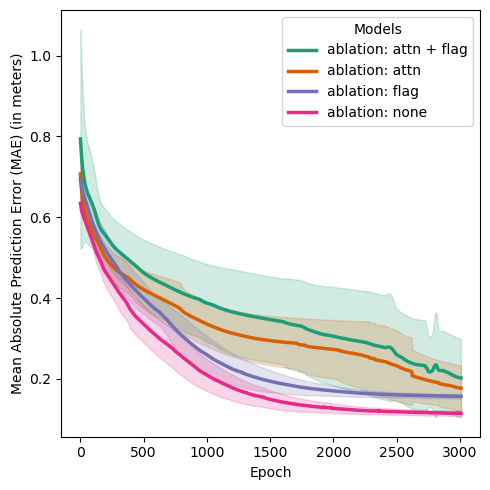

In [18]:
plt.figure(figsize=(5, 5))
model_loss_mean = np.mean(model_losses_seeds, axis=1)
model_loss_std = np.std(model_losses_seeds, axis=1)
model_energy_mean = np.mean(model_energies_seeds, axis=1)
model_energy_std = np.std(model_energies_seeds, axis=1)

for i, ext in enumerate(path_ext):
    plt.plot(range(epoch + pre_train), model_loss_mean[0][i], label="ablation: {}".format(components[i]), color=colors[i], lw=2.5)
    plt.fill_between(range(epoch + pre_train), model_loss_mean[0][i] - model_loss_std[0][i],
                     model_loss_mean[0][i] + model_loss_std[0][i], alpha=0.2, color=colors[i])
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Prediction Error (MAE) (in meters)")
plt.tight_layout()
plt.legend(title="Models")
plt.savefig("{}/components.png".format(plot_subpath), bbox_inches='tight')
plt.show()